In [1]:
import pandas
import seaborn
import sklearn
import functions as covid_lib
from numpy import hstack, array
from random import random
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.graph_objects as go
from dash.dependencies import Input, Output 

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense


In [2]:
## John Hopkins Center for Systems Science and Engineer Data Base URL
## Contains timeseries data
## This set of data is updated daily
baseURL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"

cumulated_confirmed_url = baseURL + "time_series_covid19_confirmed_global.csv"
cumulated_deaths_url    = baseURL + "time_series_covid19_deaths_global.csv"
cumulated_recovered_url = baseURL + "time_series_covid19_recovered_global.csv"

cumulated_confirmed     = pd.read_csv(cumulated_confirmed_url)
cumulated_deaths        = pd.read_csv(cumulated_deaths_url)
cumulated_recovered     = pd.read_csv(cumulated_recovered_url)

## Processed Dataset
## Combine by Country/Region
cumulated_confirmed_country = covid_lib.df_groupby_countries(cumulated_confirmed)
cumulated_deaths_country = covid_lib.df_groupby_countries(cumulated_deaths)
cumulated_recovered_country = covid_lib.df_groupby_countries(cumulated_recovered)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

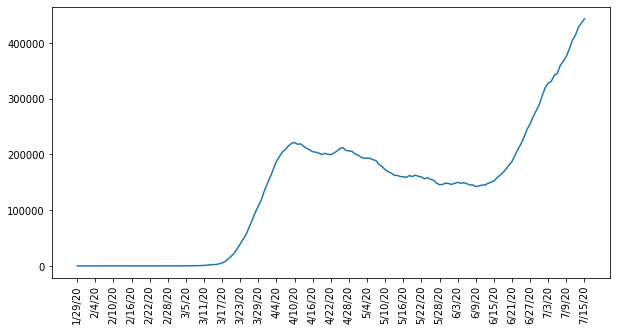

In [3]:
US_confirmed = cumulated_confirmed.loc[cumulated_confirmed["Country/Region"]=="US"].head()
total_cases, increased_case = covid_lib.df_to_timeseries(US_confirmed, 7)

figure = plt.figure(figsize = (10,5))
plt.plot(increased_case)
plt.xticks(np.arange(0, len(increased_case.dropna()), 6)) 
plt.xticks(rotation=90)
plt.savefig("Infected Case.jpg",  bbox_inches='tight')

### Predicting the change in Total Cases for 7 day

/home/mavericku/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

/home/mavericku/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Test RMSE: 29.902


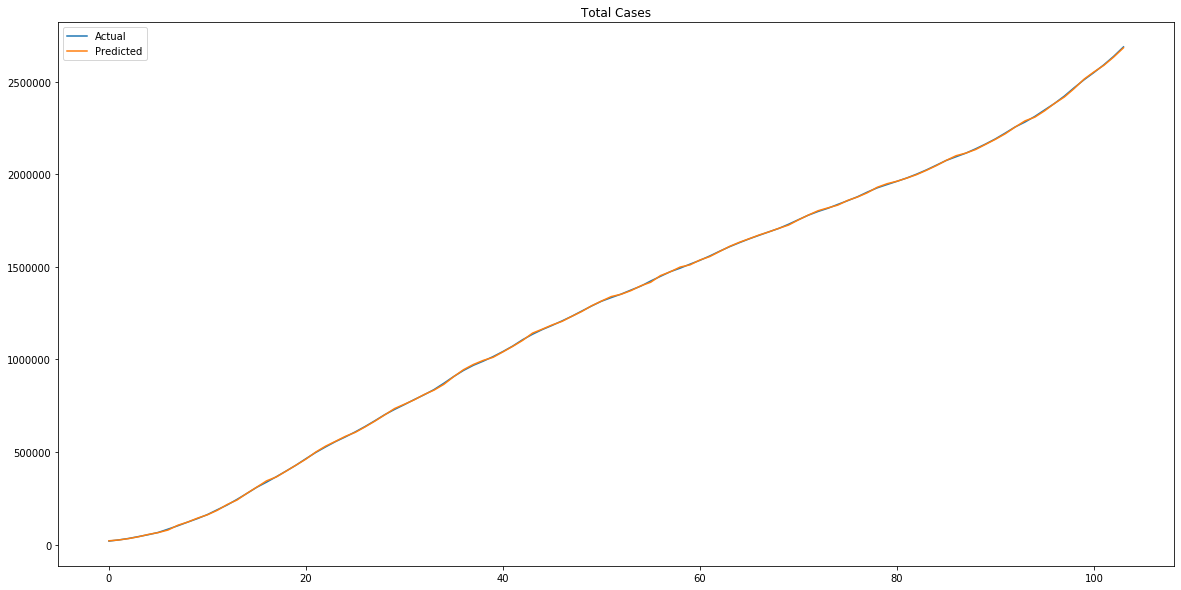

In [10]:
## This only predicts for one day
predictions_total, model_total = covid_lib.SARIMA_PREDICT_edit(total_cases,"Total Cases", order_tuple = (0,1,0), fit_param = (True, True))

### Predicting the changes for increased count for 1 day

/home/mavericku/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



Test RMSE: 26.018


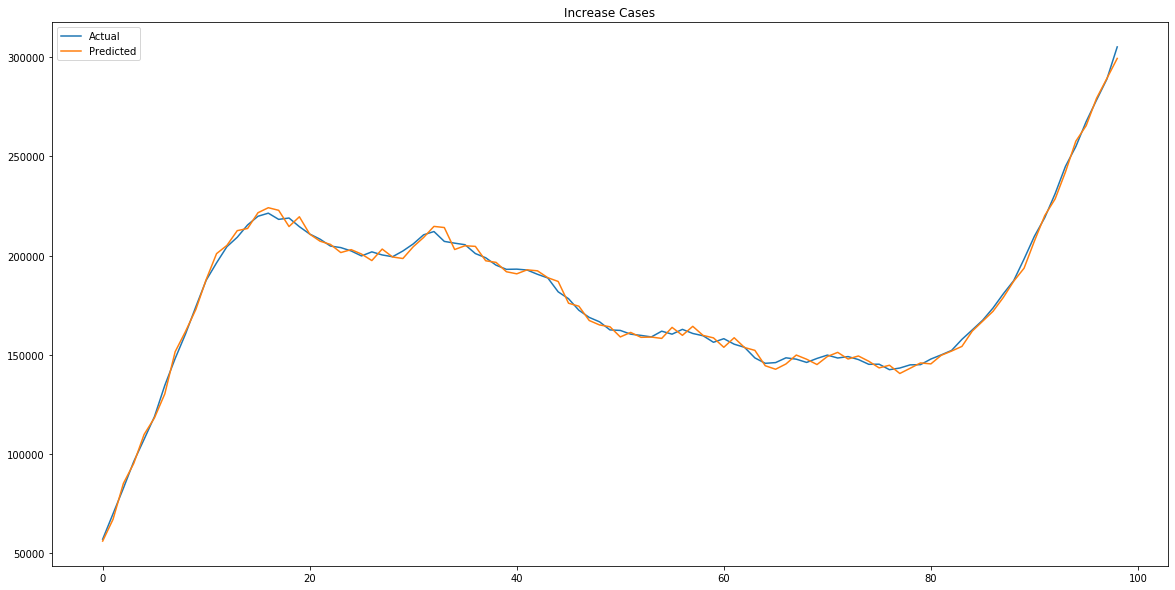

In [11]:
increase_temp = increased_case.values 
predictions_increase, model_increase = covid_lib.SARIMA_PREDICT_edit(increase_temp, "Increase Cases",  is_increase_case = True, fit_param = (True,True) )

### Testing the LSTM model

7347.10414970836

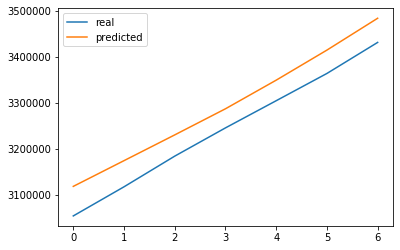

In [9]:
one_week_feature, one_week_target = covid_lib.split_sequence(total_cases.transpose()[0], 7)
two_week_feature, two_week_target = covid_lib.split_sequence(total_cases.transpose()[0], 14)

train_owf, train_owt, test_owf, test_owt = covid_lib.train_test_split_timeseries(one_week_feature, one_week_target)


covid_lib.LSTM_PREDICT(feature = train_owf,
     target = train_owt, 
     test_feature = test_owf,
     test_target = test_owt ,
     n_features = 1,
     n_steps = 7)

---

### Building the Boosted Model


In [14]:
test_input =np.load("./test files/test_input.npy") 
in_seq1 = np.load("./test files/in_seq1.npy")
in_seq2 = np.load("./test files/in_seq2.npy")
out_seq = np.load("./test files/out_seq.npy")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:


    
# define input sequence
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))

# choose a number of time steps
n_steps = 7

# convert into input/output
# print(dataset)
X, y = covid_lib.split_sequences(dataset, n_steps, 7) 
n_features = X.shape[2]

# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# fit model 
model.fit(X, y, epochs=200, verbose=0)
# demonstrate prediction 


lstm_predictions = []
for i in range(0 , len(test_input)-7):
    lstm_predictions.append(test_input[i][0])
    
for i in range(0 , len(test_input)-7):
    test_input_segment = array(test_input[i:i+7]) 
    x_input = test_input_segment.reshape((1, n_steps, n_features))
    yhat = model.predict(x_input, verbose=0) 
    lstm_predictions.append(yhat[0][0])

ValueError: cannot reshape array of size 14 into shape (1,7,3)

In [20]:
plt.plot(in_seq1_ar)
plt.plot(out_seq)
plt.plot(lstm_predictions)
plt.legend(["SARIMA Prediction" , "Real Value" , "Boosted LSTM"])
# plt.savefig("BoostedLSTMDay7.png")

NameError: name 'in_seq1_ar' is not defined